In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import folium
from IPython.display import display

In [4]:
def memory_usage_only(df):
    total_memory = df.memory_usage(deep=True).sum()
    print(f"Memory Usage: {total_memory / 1024**2:.2f} MB")
    
    #to call: memory_usage_only(df)

In [5]:
df = pd.read_csv('credit_card_transactions.csv')
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

## Starting out, our dataset contains 24 separate columns with 1,296,675 rows.
## The info table above includes a summary of the columns included: name, number of non-null entries in that column, and datatype.
## This dataset is a mix of numerical data like transaction amount, latitude/longitude coordinates, and 0/1 booleans, as well as string data like a concatenated transaction date and time value, customer name, and basic demographic data.

In [7]:
memory_usage_only(df)

Memory Usage: 1044.88 MB


## The total memory used to store the dataframe is ~1.1GB as we begin our analysis. This will be the mark which we measure our data reduction against.

# Data Cleaning

### This dataset contains a credit card number associated with each transaction, but these card numbers have been anonymized and hashed to protect user privacy. Since they are randomized, we can remove them from the dataset to reduce memory usage.

In [11]:
# drop (delete) the credit card number field 
df.drop('cc_num', axis = 1, inplace = True)

In [12]:
memory_usage_only(df)

Memory Usage: 1034.99 MB


### After deleting the useless credit card numbers we can see the total column count has decreased from 24 to 23, and we have reduced memory usage by ~10 MB.

### What additional columns can we remove to reduce the load? 
#### Column 0 = an incrementing integer for each transaction that is not needed

In [14]:
print((df['Unnamed: 0'].memory_usage(deep=True)/(1024*1024)))
print((df['trans_num'].memory_usage(deep=True)/(1024*1024)))

9.89297103881836
100.16518306732178


### We can see in the output cell above that the memory usage for the first column titled 'Unnamed' compared to the memoryusage for the transaction number column. The Unnamed column includes a unique incrementing integer for each observation. The transaction number is a unique hexidecimal string for each observation. Since the hex string is significantly longer, and uses a base-16 character space that is larger than the base-10 integer number system, it requires more than 10 times the memory to store.

### We will drop the transaction number column, and instead use the Unnamed column integer as our unique transaction identifier.

In [16]:
df.drop('trans_num', axis = 1, inplace = True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [18]:
memory_usage_only(df)

Memory Usage: 934.82 MB


## 120 MB of memory saved, reducing our total data size by ~9%

## Since we have lat/long for buyer and seller, we can delete the merchant zipcode column which is incomplete.

In [20]:
df.drop('merch_zipcode', axis = 1, inplace = True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

## Lets review trans_date_trans_time to see if it's needed

In [23]:
df.describe()

Unnamed: 0           amt           zip           lat          long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  7.035104e+01  4.880067e+04  3.853762e+01 -9.022634e+01   
std    3.743180e+05  1.603160e+02  2.689322e+04  5.075808e+00  1.375908e+01   
min    0.000000e+00  1.000000e+00  1.257000e+03  2.002710e+01 -1.656723e+02   
25%    3.241685e+05  9.650000e+00  2.623700e+04  3.462050e+01 -9.679800e+01   
50%    6.483370e+05  4.752000e+01  4.817400e+04  3.935430e+01 -8.747690e+01   
75%    9.725055e+05  8.314000e+01  7.204200e+04  4.194040e+01 -8.015800e+01   
max    1.296674e+06  2.894890e+04  9.978300e+04  6.669330e+01 -6.795030e+01   

           city_pop     unix_time     merch_lat    merch_long      is_fraud  
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  
mean   8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01  5.788652e-03  
std    3.019564e+05  1.284128e+07  5.109788e+00  1.377109e+01  7.586269e-02  
min    2.300000e+01  1.325376e+09  1.902779e+01 -1.666712e+02  0.000000e+00  
25%    7.430000e+02  1.338751e+09  3.473357e+01 -9.689728e+01  0.000000e+00  
50%    2.456000e+03  1.349250e+09  3.936568e+01 -8.743839e+01  0.000000e+00  
75%    2.032800e+04  1.359385e+09  4.195716e+01 -8.023680e+01  0.000000e+00  
max    2.906700e+06  1.371817e+09  6.751027e+01 -6.695090e+01  1.000000e+00

## Lets investigate transaction timing info a bit. I'm curious to learn how fraud is distributed by month

<Figure size 1400x1000 with 0 Axes>

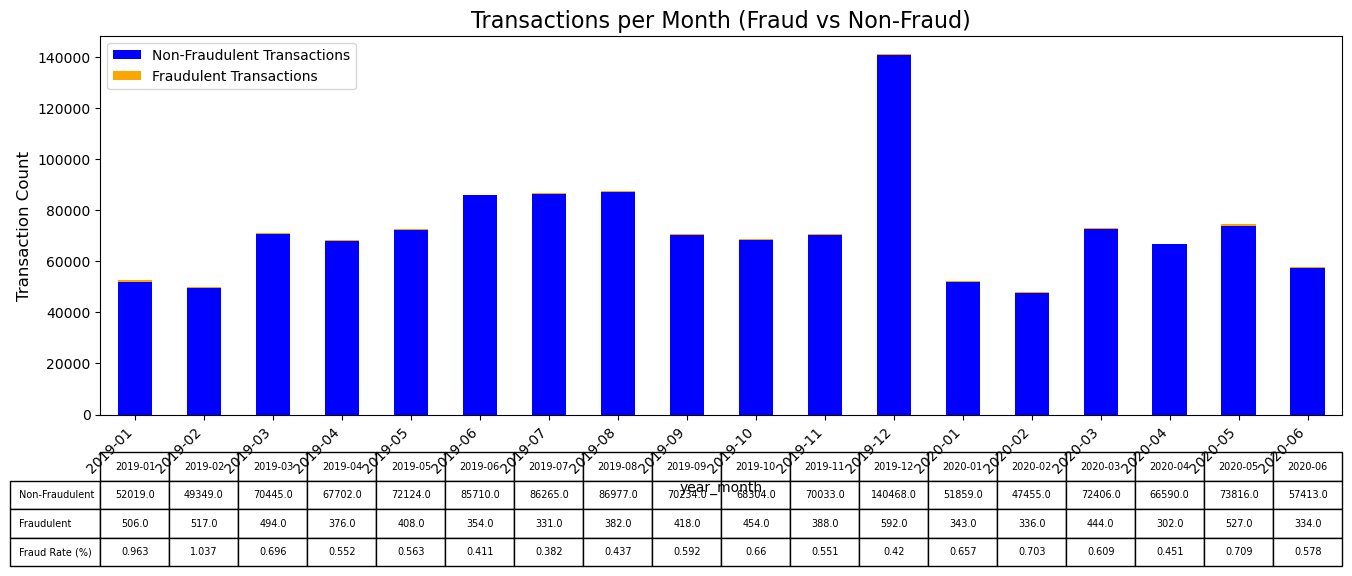

In [25]:

# ensure year_month is properly set up
df['year_month'] = pd.to_datetime(df['trans_date_trans_time']).dt.to_period('M')

# calculate the fraud rate by month
fraud_counts = df.groupby(['year_month', 'is_fraud']).size().unstack(fill_value=0)
fraud_counts['Fraud_Rate'] = (fraud_counts[1] / (fraud_counts[0] + fraud_counts[1])).fillna(0) * 100
fraud_counts['Fraud_Rate'] = fraud_counts['Fraud_Rate'].round(3)

# build a stacked bar chart
plt.figure(figsize=(14, 10))
ax = fraud_counts[[0, 1]].plot(kind='bar', stacked=True, figsize=(14, 7), color=['blue', 'orange'])
plt.title('Transactions per Month (Fraud vs Non-Fraud)', fontsize=16)
plt.ylabel('Transaction Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(['Non-Fraudulent Transactions', 'Fraudulent Transactions'], loc='upper left', fontsize=10)

# build the table
table_data_transposed = fraud_counts[[0, 1]].transpose()
fraud_rate_row = fraud_counts['Fraud_Rate']
table_with_fraud_rate = pd.concat([table_data_transposed, fraud_rate_row.to_frame().T])
table_with_fraud_rate.index = ['Non-Fraudulent', 'Fraudulent', 'Fraud Rate (%)']

# plot the table
plt.table(cellText=table_with_fraud_rate.values,
          colLabels=table_with_fraud_rate.columns.astype(str),
          rowLabels=table_with_fraud_rate.index,
          cellLoc='center', loc='bottom', bbox=[0, -0.4, 1, 0.3])

# adjust layout and show
plt.tight_layout()
plt.subplots_adjust(bottom=0.4)
plt.show()


In [26]:
total_non_fraudulent = fraud_counts[0].sum()  # Non-fraudulent transactions
total_fraudulent = fraud_counts[1].sum()      # Fraudulent transactions

# Calculate grand total
grand_total = total_non_fraudulent + total_fraudulent

# Display the totals
print(f"Total Non-Fraudulent Transactions: {total_non_fraudulent}")
print(f"Total Fraudulent Transactions: {total_fraudulent}")
print(f"Grand Total Transactions: {grand_total}")

Total Non-Fraudulent Transactions: 1289169
Total Fraudulent Transactions: 7506
Grand Total Transactions: 1296675


## This graphic contains a lot of great summary stats:
### - Overall we can see that our dataset spreads ~18 months from the beginning of 2019 through mid-2020. 
### - There is a pronounced spike in December 2019, which is nearly double the average transaction volume compared to other months. This is likely explained by seasonal holiday spending patterns.
### - We've bucketed transactions by month, and separated non-fraudlent (standard) transactions from fraudlent charges. Counts for each category are provided, and we also normalized for the variation in monthly transaction volume by creating a fraud rate by month. 
### - There is some variation in fraud rate month to month, but the changes are not large or repeated year over year, so there is not likely to be a pattern or significant correlation with the month of the transaction

In [28]:
## Lets review gender and fraud counts to determine if we can remove the column
gender_fraud_counts = df.groupby(['gender', 'is_fraud']).size().unstack(fill_value=0)

# calculate fraud rates by gender
gender_fraud_counts['Fraud_Rate'] = (gender_fraud_counts[1] / (gender_fraud_counts[0] + gender_fraud_counts[1])) * 100

# rund the fraud rate for better readability
gender_fraud_counts['Fraud_Rate'] = gender_fraud_counts['Fraud_Rate'].round(3)
print(gender_fraud_counts)

is_fraud       0     1  Fraud_Rate
gender                            
F         706128  3735       0.526
M         583041  3771       0.643


## Overall we can see that there is a fairly even split between the two genders within the dataset (~706K female transactions vs ~583K male)
## The fraud rates between the two categories are similar
## We can safely drop the gender column to save memory

In [30]:
df.drop('gender', axis = 1, inplace = True)

In [31]:
memory_usage_only(df)

Memory Usage: 872.99 MB


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype    
---  ------                 --------------    -----    
 0   Unnamed: 0             1296675 non-null  int64    
 1   trans_date_trans_time  1296675 non-null  object   
 2   merchant               1296675 non-null  object   
 3   category               1296675 non-null  object   
 4   amt                    1296675 non-null  float64  
 5   first                  1296675 non-null  object   
 6   last                   1296675 non-null  object   
 7   street                 1296675 non-null  object   
 8   city                   1296675 non-null  object   
 9   state                  1296675 non-null  object   
 10  zip                    1296675 non-null  int64    
 11  lat                    1296675 non-null  float64  
 12  long                   1296675 non-null  float64  
 13  city_pop               1296675 non-null  i

## Lets continue to hunt for data to remove. The unix time does not appear to be correct and all the dates that are provided in the trans_date_trans_time category are exactly 7 years before the time of the converted unix_time value
## We will remove the unix_time value since the trans_date value is easier to read and it doesn't really matter what year the transaction was in

In [34]:
df.drop('unix_time', axis = 1, inplace = True)

In [35]:
memory_usage_only(df)

Memory Usage: 863.10 MB


## We can also drop the street, city, state, and zip columns since we have a lat/long for each transaction

In [37]:
df.drop('street', axis = 1, inplace = True)
df.drop('city', axis = 1, inplace = True)
df.drop('zip', axis = 1, inplace = True)

In [38]:
memory_usage_only(df)

Memory Usage: 693.83 MB


## Lets look at fraud frequency by transaction value

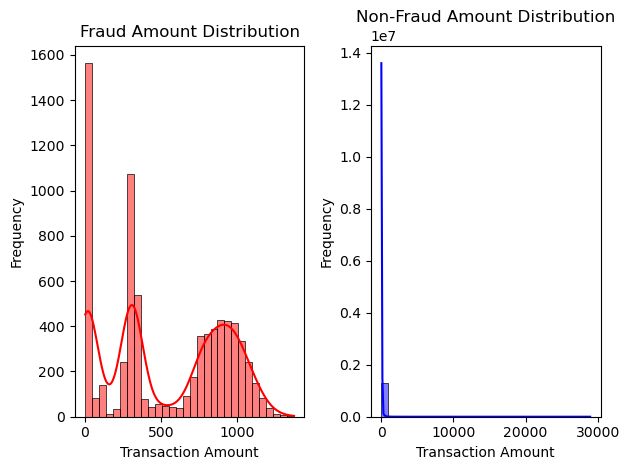

In [40]:
# https://seaborn.pydata.org/generated/seaborn.histplot.html
# plot fraud and non-fraud distributions for 'amt'

# fraud bucket
plt.subplot(1, 2, 1)
sns.histplot(df[df['is_fraud'] == 1]['amt'], bins=30, kde=True, color='red')
plt.title('Fraud Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# non-fraud bucket
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_fraud'] == 0]['amt'], bins=30, kde=True, color='blue')
plt.title('Non-Fraud Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## There are a few interesting points in this chart:
### The range of values for fraudulent transactions is much smaller than the range of non-fraud transactions
### The outliers at the top end of the amount range for non-fraud transactions are masking a lot of the data for lower transactions. Lets review the subset of transactions between $1 and $500 to remove some of the noise

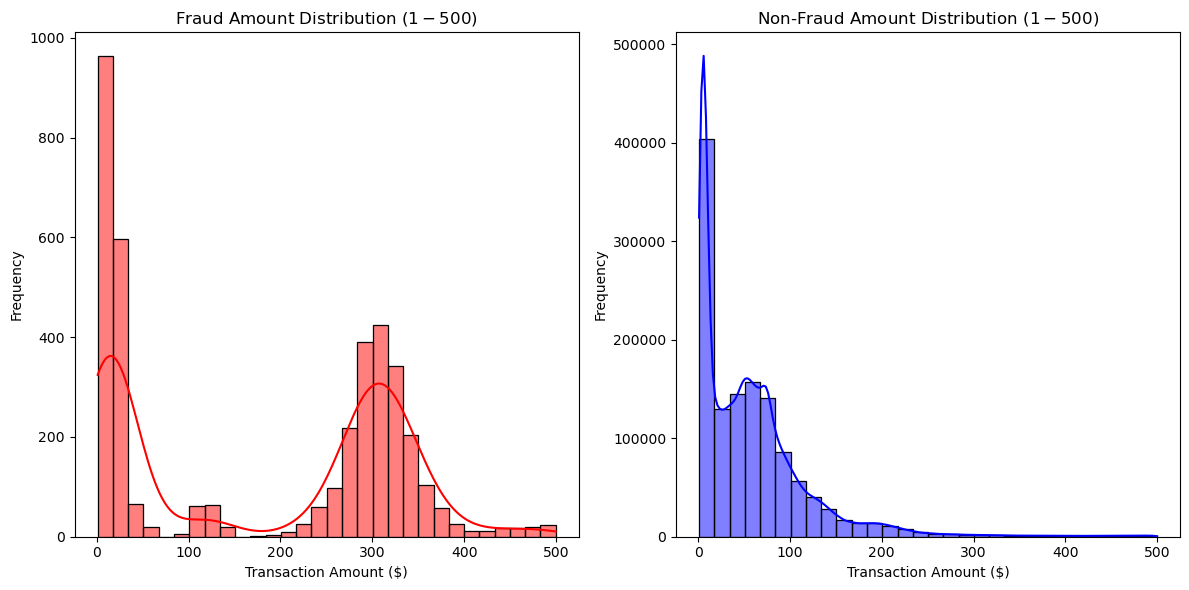

In [42]:
# https://seaborn.pydata.org/generated/seaborn.histplot.html
# filter the data for transactions with amounts between 1 and 500
filtered_data = df[(df['amt'] > 1) & (df['amt'] <= 500)]
plt.figure(figsize=(12, 6))

# fraud transactions
plt.subplot(1, 2, 1)
sns.histplot(filtered_data[filtered_data['is_fraud'] == 1]['amt'], bins=30, kde=True, color='red')
plt.title('Fraud Amount Distribution ($1 - $500)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')

# non-fraud transactions
plt.subplot(1, 2, 2)
sns.histplot(filtered_data[filtered_data['is_fraud'] == 0]['amt'], bins=30, kde=True, color='blue')
plt.title('Non-Fraud Amount Distribution ($1 - $500)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Here we can see a significant "bunching" of fraudulent transactions right around the $300 dollar mark. This bunching is not present in non-fraud transactions

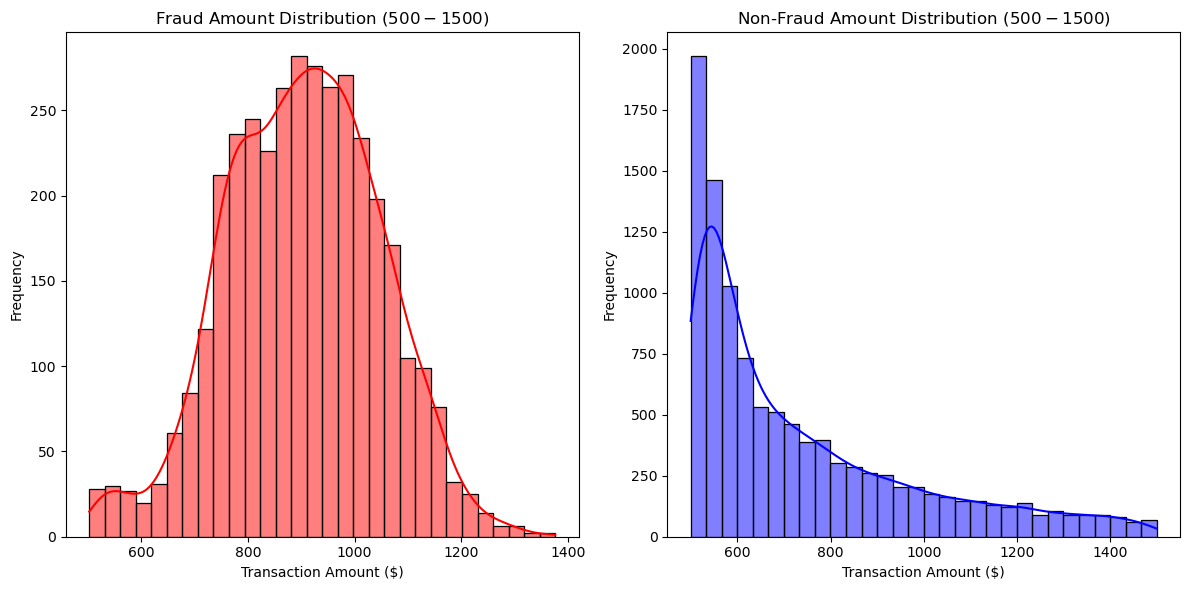

In [44]:
# https://seaborn.pydata.org/generated/seaborn.histplot.html
# filter the data for transactions with amounts between 1 and 500
filtered_data = df[(df['amt'] > 500) & (df['amt'] <= 1500)]
plt.figure(figsize=(12, 6))

# fraud transactions
plt.subplot(1, 2, 1)
sns.histplot(filtered_data[filtered_data['is_fraud'] == 1]['amt'], bins=30, kde=True, color='red')
plt.title('Fraud Amount Distribution ($500 - $1500)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')

# non-fraud transactions
plt.subplot(1, 2, 2)
sns.histplot(filtered_data[filtered_data['is_fraud'] == 0]['amt'], bins=30, kde=True, color='blue')
plt.title('Non-Fraud Amount Distribution ($500 - $1500)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## We can see like the sub-500 dollar class, there is also a significant concentration of fraudulent transactions around the 950 to 1,000 dollar range that differs significantly from the non-fraud class

## We can continue to repurpose this code snippet to inspect different classes like transaction timing
## Lets bucket the transactions by hour (24 buckets based on transaction time) to see if there is anything interesting 

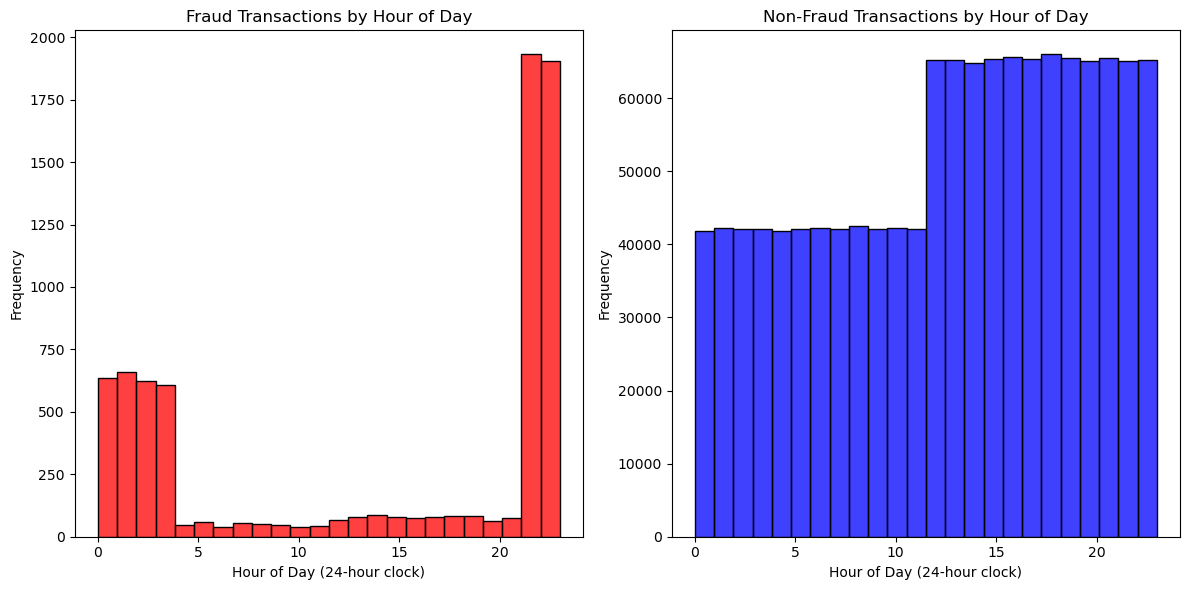

In [47]:
# https://seaborn.pydata.org/generated/seaborn.histplot.html
# clean 'trans_date_trans_time' column to datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# extract the hour from the transaction time
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour

# plot fraud and non-fraud distributions for transaction time
plt.figure(figsize=(12, 6))

# fraud transactions
plt.subplot(1, 2, 1)
sns.histplot(df[df['is_fraud'] == 1]['hour_of_day'], bins=24, kde=False, color='red')
plt.title('Fraud Transactions by Hour of Day')
plt.xlabel('Hour of Day (24-hour clock)')
plt.ylabel('Frequency')

# non-fraud transactions
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_fraud'] == 0]['hour_of_day'], bins=24, kde=False, color='blue')
plt.title('Non-Fraud Transactions by Hour of Day')
plt.xlabel('Hour of Day (24-hour clock)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Right away we can see a big difference in the way that transactions are distributed temporally
## Non-fraud transactions are lower at night time and higher during the daytime as one would expect
## Fraud transctions on the other hand have a significant spike between 22 and 2400, with much lower incidences during the daytime
## This is also a significant divergence between the two datasets so it will be interesting to see if this is a factor in our model

## Lets review the DOB column to see if there is any significant difference between classes

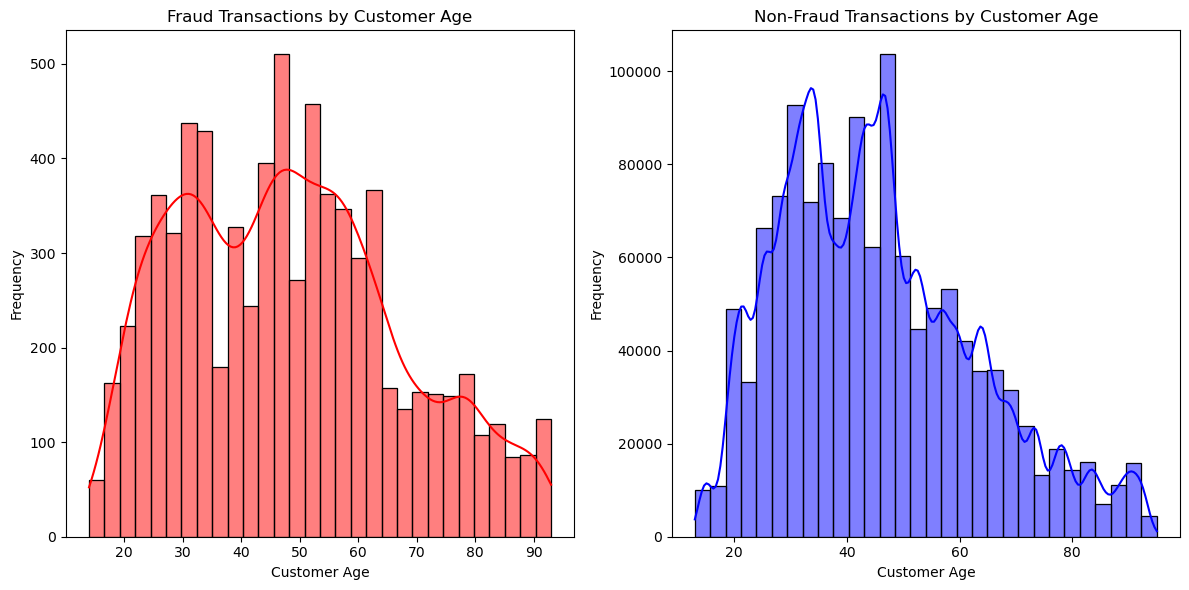

In [50]:
# https://seaborn.pydata.org/generated/seaborn.histplot.html
# check 'dob' column is in datetime format
df['dob'] = pd.to_datetime(df['dob'])

# calculate customer age at the time of the transaction
df['customer_age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

# adjust for transactions before the customer's birthday
df['customer_age'] -= (df['trans_date_trans_time'].dt.month < df['dob'].dt.month) | \
                        ((df['trans_date_trans_time'].dt.month == df['dob'].dt.month) & 
                         (df['trans_date_trans_time'].dt.day < df['dob'].dt.day))

# plot fraud and non-fraud distributions for customer age
plt.figure(figsize=(12, 6))

# fraud transactions
plt.subplot(1, 2, 1)
sns.histplot(df[df['is_fraud'] == 1]['customer_age'], bins=30, kde=True, color='red')
plt.title('Fraud Transactions by Customer Age')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')

# non-fraud transactions
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_fraud'] == 0]['customer_age'], bins=30, kde=True, color='blue')
plt.title('Non-Fraud Transactions by Customer Age')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Overall it looks like a fairly even distribution of ages in both datasets. There is a slight bias towards younger ages in the fraud class that is not present in the non-fraud class

## Now lets explore how distance between customer location and merchant location are related

In [53]:
#make transaction time in datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

#distance calc/flags
def calculate_distance(row):
    customer_coords = (row['lat'], row['long'])
    merchant_coords = (row['merch_lat'], row['merch_long'])
    return geodesic(customer_coords, merchant_coords).km

#add additional column
df['distance_km'] = df.apply(calculate_distance, axis=1)

#add a flag for non local transactions
df['not_local'] = df['distance_km'].apply(lambda x: 1 if x > 50 else 0)

#add distance category
def categorize_distance(distance):
    if distance <= 10:
        return 'Local'
    elif distance <= 50:
        return 'Regional'
    else:
        return 'Long Distance'

df['distance_category'] = df['distance_km'].apply(categorize_distance)

#fraud Rate by Distance Category
fraud_rate_by_distance = df.groupby('distance_category')['is_fraud'].mean() * 100
print(fraud_rate_by_distance)

distance_category
Local            0.511654
Long Distance    0.583517
Regional         0.562794
Name: is_fraud, dtype: float64


C:\Users\B\AppData\Local\Temp\ipykernel_19592\2651815806.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_distance = df.groupby('distance_category')['is_fraud'].mean() * 100


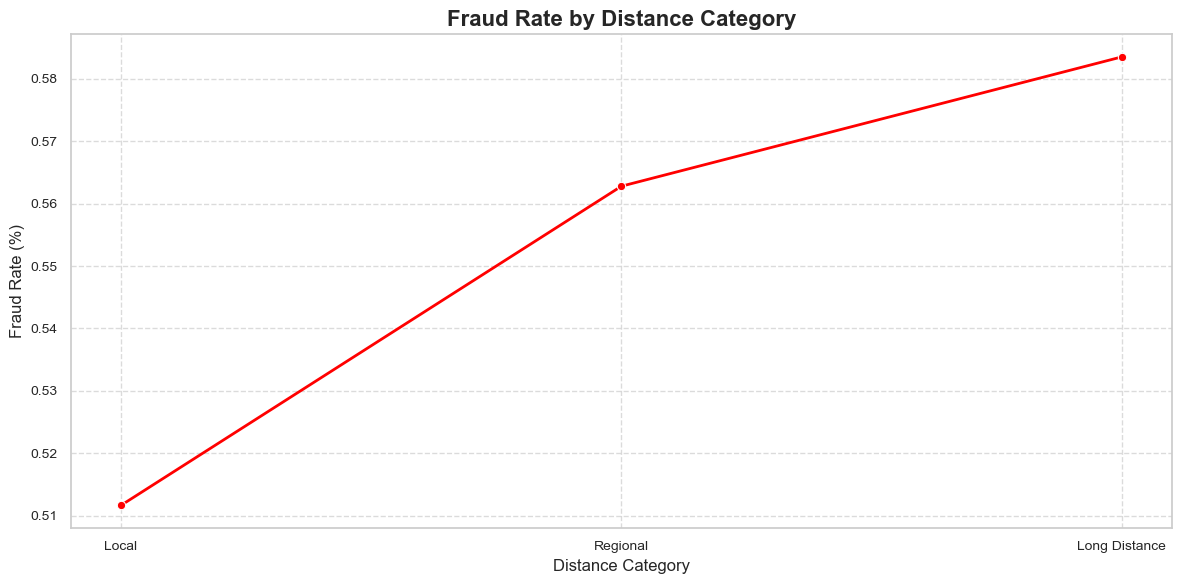

In [54]:
###fraud rate vs distance  
#theme set
sns.set_theme(style="whitegrid")

#categorize distance with an order
distance_order = ['Local', 'Regional', 'Long Distance']
df['distance_category'] = pd.Categorical(
    df['distance_category'], categories=distance_order, ordered=True
)

#fraud rate by distance subcat
fraud_rate_by_distance = df.groupby('distance_category')['is_fraud'].mean() * 100

#plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=fraud_rate_by_distance, marker='o', color='red', linewidth=2)

#labels and such
plt.title('Fraud Rate by Distance Category', fontsize=16, fontweight='bold')
plt.xlabel('Distance Category', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [55]:
#geospatial Visualization
def create_transaction_map(data, fraud_only=False, max_points=1000):
    #center the map at the average lat/long (basically get map of usa) 
    map_center = [data['lat'].mean(), data['long'].mean()]
    transaction_map = folium.Map(location=map_center, zoom_start=6)

    #filter for fraud only data 
    if fraud_only:
        data = data[data['is_fraud'] == 1]

    #limit number of points to visualize
    if len(data) > max_points:
        data = data.sample(n=max_points, random_state=42)

    #+ each transaction as a circle marker to be visible on the map
    for _, row in data.iterrows():
        location = [row['lat'], row['long']]
        popup_text = f"""
        Merchant: {row['merchant']}<br>
        Amount: ${row['amt']:.2f}<br>
        Fraud: {'Yes' if row['is_fraud'] else 'No'}<br>
        Local Transaction: {'No' if row['not_local'] else 'Yes'}
        """
        color = 'red' if row['is_fraud'] else 'green'
        folium.CircleMarker(
            location=location,
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            popup=popup_text,
        ).add_to(transaction_map)

    return transaction_map

transaction_map = create_transaction_map(df, fraud_only=False, max_points=5000)  
display(transaction_map)

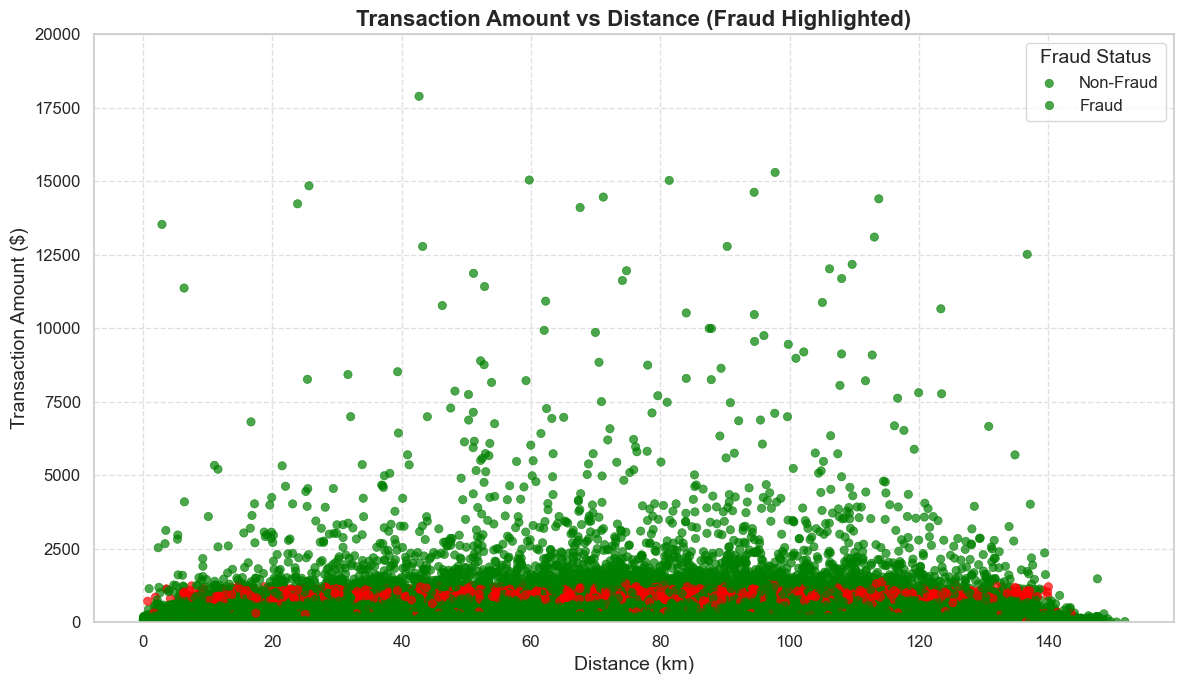

In [56]:
#scatter plot for transaction Amount vs Distance
sns.set_theme(style="whitegrid")

#basic scatter plot
plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    data=df,
    x='distance_km',
    y='amt',
    hue='is_fraud',
    palette={0: 'green', 1: 'red'},
    alpha=0.7,  # Add transparency for overlapping points
    edgecolor=None
)

#labels and such 
plt.title('Transaction Amount vs Distance (Fraud Highlighted)', fontsize=16, fontweight='bold')
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Transaction Amount ($)', fontsize=14)
#limit transaction amount to $20000 (only lose a few points and none are fraud) 
plt.ylim(0, 20000)  
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#legend
legend = plt.legend(
    title='Fraud Status',
    labels=['Non-Fraud', 'Fraud'],
    fontsize=12,
    title_fontsize=14,
    loc='upper right',
    frameon=True
)
legend.get_frame().set_alpha(0.75) 

# Add gridlines for readability
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

In [57]:
#set up machine learning 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [58]:
#normalize the distance feature
scaler = MinMaxScaler()
df['distance_km_normalized'] = scaler.fit_transform(df[['distance_km']])

#feature matrix and target
#can add other features as necessary
X = df[['distance_km_normalized', 'not_local', 'amt']]  
y = df['is_fraud']

#separate and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#random forest model to train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

#finally eval. the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.45      0.23      0.31      2252

    accuracy                           0.99    389003
   macro avg       0.72      0.61      0.65    389003
weighted avg       0.99      0.99      0.99    389003

